In [53]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
import os
from keras.callbacks import Callback
from keras.utils import array_to_img

In [54]:
ds = tfds.load("fashion_mnist", split="train")

In [55]:
dsiter = ds.as_numpy_iterator()

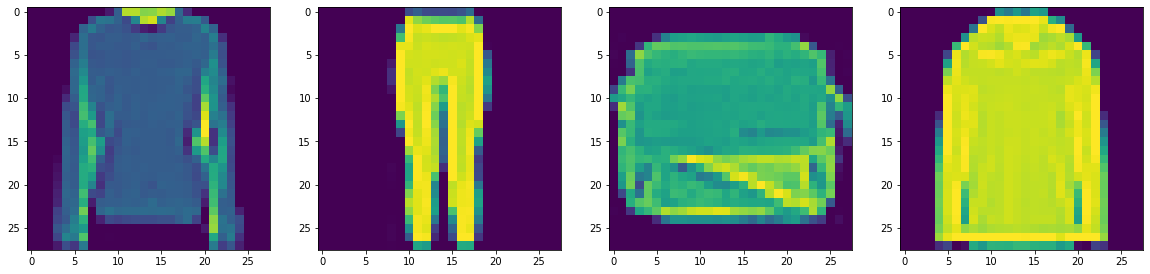

In [56]:
fig, ax = plt.subplots(ncols=4, figsize= (20,20))
for i in range(4):
    batch = dsiter.next()
    ax[i].imshow(np.squeeze(batch["image"]))

In [57]:
def scaleimage(data):
    image = data["image"]
    return  image/255

In [58]:
ds = tfds.load("fashion_mnist", split="train")
ds = ds.map(scaleimage)
ds = ds.cache()
ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [59]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [60]:
def buildgenerator():
    model = Sequential()
    model.add(Dense(7*7*128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128,4,padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128,4,padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(1,4,padding="same", activation="sigmoid"))
    return model

In [61]:
generator = buildgenerator()
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_6 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [62]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

1/1 [==============================] - 0s 128ms/step


(4, 28, 28, 1)

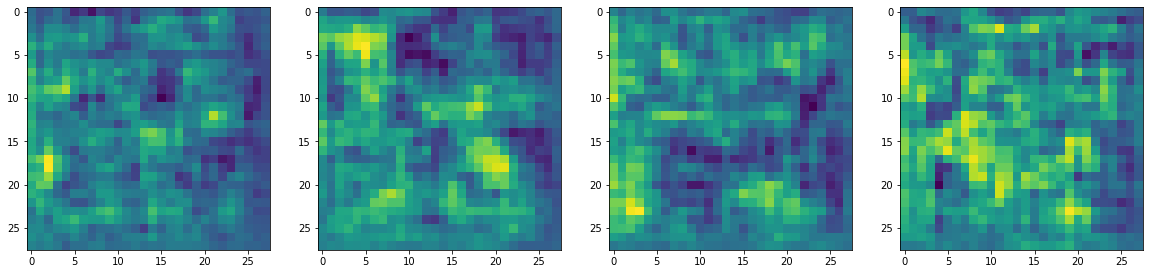

In [63]:
fig, ax = plt.subplots(ncols=4, figsize= (20,20))
for i, img in enumerate(img):
    ax[i].imshow(np.squeeze(img))

In [64]:
def builddiscriminator():
    model = Sequential()
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation="sigmoid"))
    return model

In [65]:
discriminator = builddiscriminator()
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_15 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_16 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 128)      

In [66]:
gopt = Adam(learning_rate=0.0001)
dopt = Adam(learning_rate=0.00001)
gloss = BinaryCrossentropy()
dloss = BinaryCrossentropy()

In [67]:
class gan(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator
    def compile(gopt, dopt, gloss, dloss, *args, **kwargs):
        super().compile(*args, **kwargs)
        # self.gopt = gopt
        # self.dopt = dopt
        # self.gloss = gloss
        # self.dloss = dloss
    def trainstep(self, batch):
        realimages = batch
        fakeimages = self.generator(tf.random.normal((128,128,1)), training = False)
        with tf.GradientTape as tape:
            ycapreal = self.discriminator(realimages, training= True)
            ycapfake = self.discriminator(fakeimages, training= True)
            ycaprealfake = tf.concat([ycapreal, ycapfake], axis = 0)
            yrealfake = tf.concat([tf.zeros_like(ycapreal), tf.ones_like(ycapfake)], axis=0)

            noisereal = 0.15 * tf.random.uniform(tf.shape(ycapreal))
            noisefake = -0.15 * tf.random.uniform(tf.shape(ycapfake))
            yrealfake += tf.concat([noisereal, noisefake], axis = 0)
            totaldloss = self.dloss(yrealfake, ycaprealfake)
        dgrad = tape.gradient(totaldloss, self.discriminator.trainable_variables)
        self.dopt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        with tf.GradientTape as gtape:
            genimages = self.generator(tf.random.normal((128,128,1)), training = True)
            predlabels = self.discriminator(genimages, training = False )
            totalgloss = self.gloss(tf.zeros_like(predlabels), predlabels)
        ggrad = gtape.gradient(totalgloss, self.generator.trainable_variables)
        self.gopt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        return{"dloss = ": totaldloss, "gloss": totalgloss}


In [68]:
fashiongan = gan(generator, discriminator)
fashiongan.compile(gopt, dopt, gloss, dloss)

ValueError: Could not interpret optimizer identifier: <keras.losses.BinaryCrossentropy object at 0x00000291B53B1D30>

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [ ]:
hist = fashiongan.fit(ds, epochs=50)